## Librerias

In [24]:
# Tratamiento de datos
import pandas as pd
from datetime import datetime
import numpy as np

# NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Regex
import re

# Vectorización
from sklearn.feature_extraction.text import CountVectorizer

# Clusterización
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Visualización
import matplotlib.pyplot as plt

# Warnings
import warnings
warnings.filterwarnings("ignore")

## Carga de datos

In [2]:
df = pd.read_csv("..\\data\\processed\\feature_engeering.csv", index_col=0, parse_dates=["date"])

## Análisis de sentimientos

En este apartado simplemente vamos a realizar las mismas modificaciones y transformaciones que utilizamos en el primer notebook de NLP para así tenerlo en nuestro nuevo DataFrame, y desde ahí proseguir con el trabajo de NLP.

In [3]:
sia = SentimentIntensityAnalyzer()

res = {}

for i, x in df.iterrows():
    des = x["description"]
    repo_name = x["repo_name"]
    res[repo_name] = sia.polarity_scores(des)

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index":"repo_name"})
vaders = vaders.merge(df, how="left")

vaders.head()

,repo_name,neg,neu,pos,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,awesome-python,0.0,0.687,0.313,0.6249,2018-12-18,1,58777,11448,3209,439,"A curated list of awesome Python frameworks, l...",5.0,1.0
1,awesome-python,0.0,0.687,0.313,0.6249,2018-12-19,1,58801,11454,3209,439,"A curated list of awesome Python frameworks, l...",6.0,1.0
2,awesome-python,0.0,0.687,0.313,0.6249,2018-12-20,1,58840,11455,3209,439,"A curated list of awesome Python frameworks, l...",0.0,1.0
3,awesome-python,0.0,0.687,0.313,0.6249,2018-12-21,1,58882,11465,3209,440,"A curated list of awesome Python frameworks, l...",1.0,1.0
4,awesome-python,0.0,0.687,0.313,0.6249,2018-12-22,1,58936,11470,3209,439,"A curated list of awesome Python frameworks, l...",2.0,1.0


Eliminamos neg, neu y pos porque como vimos en el anterior notebook de nlp, son colineales con compund que nos aporta información global sobre el sentmiento de la descripción.

In [4]:
vaders.drop(columns=["neg", "neu", "pos"], inplace=True)

vaders.head()

,repo_name,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,awesome-python,0.6249,2018-12-18,1,58777,11448,3209,439,"A curated list of awesome Python frameworks, l...",5.0,1.0
1,awesome-python,0.6249,2018-12-19,1,58801,11454,3209,439,"A curated list of awesome Python frameworks, l...",6.0,1.0
2,awesome-python,0.6249,2018-12-20,1,58840,11455,3209,439,"A curated list of awesome Python frameworks, l...",0.0,1.0
3,awesome-python,0.6249,2018-12-21,1,58882,11465,3209,440,"A curated list of awesome Python frameworks, l...",1.0,1.0
4,awesome-python,0.6249,2018-12-22,1,58936,11470,3209,439,"A curated list of awesome Python frameworks, l...",2.0,1.0


In [5]:
df = vaders.copy()

## Limpieza description

Debido a que nltk nos permite realizar el análisis de sentimientos sin limpiar el texto hemos avanzado hasta aquí sin tener que pasar por tal proceso, pero para los siguientes pasos es necesario.

### Signos de puntuación

In [6]:
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_description(des):
    return signos.sub('', des.lower())

df['description'] = df['description'].apply(signs_description)
df['description'].head()

0    a curated list of awesome python frameworks li...
1    a curated list of awesome python frameworks li...
2    a curated list of awesome python frameworks li...
3    a curated list of awesome python frameworks li...
4    a curated list of awesome python frameworks li...
Name: description, dtype: object

In [7]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642" 
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text.lower())


df['description'] = df['description'].apply(remove_emojis)
df['description'].head()

0    a curated list of awesome python frameworks li...
1    a curated list of awesome python frameworks li...
2    a curated list of awesome python frameworks li...
3    a curated list of awesome python frameworks li...
4    a curated list of awesome python frameworks li...
Name: description, dtype: object

### Stopwords

In [8]:
stopwords_words = stopwords.words('english')

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in stopwords_words])

df['description'] = df['description'].apply(remove_stopwords)
df.head()

,repo_name,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,awesome-python,0.6249,2018-12-18,1,58777,11448,3209,439,curated list awesome python frameworks librari...,5.0,1.0
1,awesome-python,0.6249,2018-12-19,1,58801,11454,3209,439,curated list awesome python frameworks librari...,6.0,1.0
2,awesome-python,0.6249,2018-12-20,1,58840,11455,3209,439,curated list awesome python frameworks librari...,0.0,1.0
3,awesome-python,0.6249,2018-12-21,1,58882,11465,3209,440,curated list awesome python frameworks librari...,1.0,1.0
4,awesome-python,0.6249,2018-12-22,1,58936,11470,3209,439,curated list awesome python frameworks librari...,2.0,1.0


## Lemmatización

In [9]:
def word_lemmatizer(x):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in x.split()])

df['description'] = df['description'].apply(word_lemmatizer)
df['description'].head()

0    curated list awesome python framework library ...
1    curated list awesome python framework library ...
2    curated list awesome python framework library ...
3    curated list awesome python framework library ...
4    curated list awesome python framework library ...
Name: description, dtype: object

## Vectorización

In [10]:
vectorizer_c = CountVectorizer()
vectorizer_c.fit(df['description'])

X_baseline_c = vectorizer_c.transform(df['description'])

In [12]:
X_baseline_c.shape

(168687, 6825)

## Clusterización

In [21]:
kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42).fit(X_baseline_c)
                for k in range(2, 21)]
inertias = [model.inertia_ for model in kmeans_per_k]

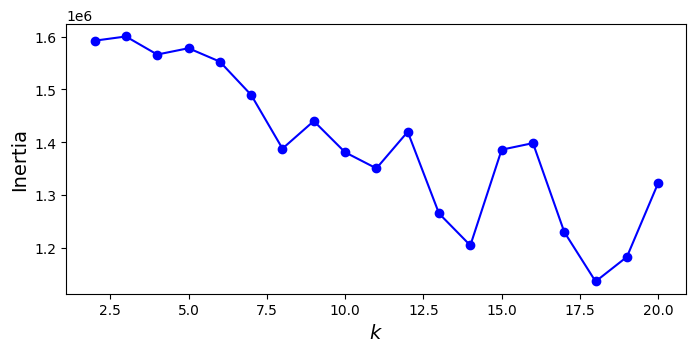

In [23]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 21), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)


plt.show()

In [27]:
silhouette_scores = [silhouette_score(X_baseline_c, model.labels_)
                     for model in kmeans_per_k[2:12]]

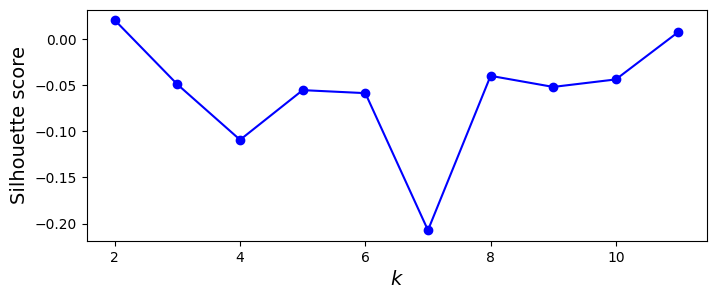

In [28]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 12), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [29]:
kmeans = MiniBatchKMeans(8, random_state=42).fit(X_baseline_c)

In [31]:
df['cluster'] = kmeans.labels_
df.head()

,repo_name,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user,cluster
0,awesome-python,0.6249,2018-12-18,1,58777,11448,3209,439,curated list awesome python framework library ...,5.0,1.0,4
1,awesome-python,0.6249,2018-12-19,1,58801,11454,3209,439,curated list awesome python framework library ...,6.0,1.0,4
2,awesome-python,0.6249,2018-12-20,1,58840,11455,3209,439,curated list awesome python framework library ...,0.0,1.0,4
3,awesome-python,0.6249,2018-12-21,1,58882,11465,3209,440,curated list awesome python framework library ...,1.0,1.0,4
4,awesome-python,0.6249,2018-12-22,1,58936,11470,3209,439,curated list awesome python framework library ...,2.0,1.0,4


In [39]:
cluster_texts_dict = {i: [] for i in range(8)}
for index, row in df.iterrows():
    cluster_texts_dict[row['cluster']].append(row['description'])

In [47]:
cluster_data = [{'cluster_id': cluster_id, 'text': text} for cluster_id, texts in cluster_texts_dict.items() for text in texts]

In [49]:
cluster_df = pd.DataFrame(cluster_data)

In [52]:
cluster_df.drop_duplicates(inplace=True)

In [59]:
cluster_df[cluster_df["cluster_id"] == 0]

,cluster_id,text
0,0,raven legacy python client sentry getsentrycom...
2,0,openai python library provides convenient acce...
13,0,python fire library automatically generating c...
1221,0,exploring python counter-intuitive snippet thi...
1238,0,artistic qr code python animated gif qr code- ...
1247,0,comprehensive python cheatsheet
2075,0,textual rapid application development framewor...
2110,0,lean application framework python build sophis...
2125,0,playground cheatsheet learning python collecti...
2238,0,collection simple python mini project enhance ...


In [61]:
cluster_df[cluster_df["cluster_id"] == 1]

,cluster_id,text
2656,1,learn design large-scale system prep system de...
3803,1,pre-trained reproduced deep learning model
3804,1,library deep learning model datasets designed ...
3985,1,simplified interface tensorflow mimicking scik...
3987,1,library transfer learning reusing part tensorf...
...,...,...
68987,1,freeanchor learning match anchor visual object...
68988,1,python script illustrating convolutional neura...
68989,1,awesome task manager written python computer
68990,1,async requests-like httplib python
